## Training Notebook

### First and foremost... sorry, this was not originally built with other people in mind.

### General Approach
I saw best performance from my models when I mixed augmented (skewed, cropped, rotated, etc.) photos into the data set, so my training workflow generally looked like:  
1. Create augmented copies of all photos, and save them in their own directory with its own CSV.  
2. Load the real data and the augmented data into a combined dataframe.  
3. Balance the data so the count of photos with baby (values 1.0, 2.0) equals the count of photos without baby (value 0.0).  
4. Either load the most recent model to retrain, or generate a new one.  
5. Train 3-5 epochs at a time several times.  
6. When I'm happy with the loss, save the model.  
7. Infer over the entire dataset. Produce a graph of the results.

In [1]:
"""General setup"""
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import scipy
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv

# Restrict TensorFlow to only use the first GPU
try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass 

## Step 1: Create augmented photos

In [10]:
"""Generate augmented copies of all photos and save to file"""

datatoaugDF = pd.read_csv('data/data.csv')
Xaug = []
yaug = []
for i in range(len(datatoaugDF.index)):
    path = datatoaugDF.iloc[i]['ResizedPath']
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    value = datatoaugDF.iloc[i]['Value']
    Xaug.append(image)
    yaug.append(value)

Xaug = np.array(Xaug)
print(f'Xaug Shape {Xaug.shape}')
Xaug = Xaug/255
Xaug = Xaug.reshape(-1, 135, 240,1)

# Create numpy array of output values (already 0 or 1)
# Transform to categorical. Use the number of classes as the dimension for the last dense layer in the model
yaug = np.array(yaug)


import csv
import os
OUTPUT_DIRECTORY_AUGMENTED = 'C:\\Users\\parki\\Documents\\GitHub\\Python-Practice\\Sleep_Schedule\\scripts\\static\\Augmented'

#Clear existing augmented files
files_list = [os.path.join(OUTPUT_DIRECTORY_AUGMENTED, file) for file in os.listdir(OUTPUT_DIRECTORY_AUGMENTED)]
for file in files_list:
    os.remove(file)

datagen = ImageDataGenerator(
    #brightness_range= [.95, 1.05], # Causes image to scale back to 0-255
    rotation_range= 3,
    width_shift_range= .05,
    height_shift_range= .05,
    zoom_range= 0.2, 
    shear_range= 0.1
)
    
with open('data/augmenteddata.csv', 'w', newline='') as f:
    csv.writer(f).writerow(['FilePath','ResizedPath','Value'])
    
    complete_cycles = 5
    #Input data size = batch_size*multiple
    batch_size = 53
    multiple = 37

    for k in range(complete_cycles):
        for i in range(multiple):
            img_list, value_list = datagen.flow(Xaug, yaug, batch_size= batch_size).next()
            for j in range(batch_size):
                img = img_list[j].reshape(135, 240,1)
                img = img*255
                value = value_list[j]

                filename = f'augmented{str(k)+str(i)+str(j)}.png'
                filepath = f'{OUTPUT_DIRECTORY_AUGMENTED}\\{filename}'
                cv2.imwrite(filepath, img)
                csv.writer(f).writerow(['', filepath, value])
        

Xaug Shape (1961, 135, 240)


## Steps 2 & 3: Load data, combining augmented images with real images. Balance data.

In [16]:
"""Load dataset, normalize and split into training and testing"""

df = pd.read_csv('data/data.csv')
augdf = pd.read_csv('data/augmenteddata.csv')

augdf2 = augdf.loc[augdf['Value'] == 0.0]
df = pd.concat([df, augdf2])

dataset_value_counts = df['Value'].value_counts()
print(f'Data counts: \n{dataset_value_counts}')

#Get sample dataframes of each value type
min_available_dict = df['Value'].value_counts().to_dict()
minimum_key, min_available = min(min_available_dict.items(), key= lambda x: x[1])


if minimum_key in [1.0, 2.0]:
    sample_size = min([min_available_dict.get(0.0), 2*min_available])
else: sample_size = min_available

if sample_size % 2:
    sample_size -= 1

bedEmptyDF = df.loc[df['Value'] == 0.0].sample(n= sample_size)
babyInBedDF = df.loc[(df['Value'] == 1.0) | (df['Value'] == 2.0)].sample(n= sample_size)
# babyInBedDF = df.loc[(df['Value'] == 1.0)].sample(n= sample_size//2)
# babyAsleepDF = df.loc[(df['Value'] == 2.0)].sample(n= sample_size//2)

#Combine and scramble
#combinedDF = pd.concat([bedEmptyDF, babyInBedDF, babyAsleepDF])
combinedDF = pd.concat([bedEmptyDF, babyInBedDF])
combinedDF = combinedDF.sample(frac=1).reset_index(drop=True)
training_data_counts = combinedDF['Value'].value_counts()
print(f'Training data counts: \n{training_data_counts}')
print(f'Total: {combinedDF.index.size}')

training_data = []
for i in range(len(combinedDF.index)):
    path = combinedDF.iloc[i]['ResizedPath']
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    value = combinedDF.iloc[i]['Value']
    training_data.append([image, value])
X = []
y = []
for feature, value in training_data:
    X.append(feature)
    if value in [1.0, 2.0]:
        y.append(1)
    elif value == 0.0:
        y.append(0)

# Create numpy array of images, normalize values between 0 and 1
# Reshape array (-1 unknown qty images, 135 pixels high, 240 pixels long, 1 value per pixel)
X = np.array(X)
print(f'X Shape {X.shape}')
X = X/255
X = X.reshape(-1, 135, 240,1)

# Create numpy array of output values (already 0 or 1)
# Transform to categorical. Use the number of classes as the dimension for the last dense layer in the model
y = np.array(y)
y_cat = to_categorical(y, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size= 0.1)

Data counts: 
0.0    2816
2.0     859
1.0     629
Name: Value, dtype: int64
Training data counts: 
0.0    1258
2.0     713
1.0     545
Name: Value, dtype: int64
Total: 2516
X Shape (2516, 135, 240)


## Step 4: Either load the most recent model to retrain, or build a new one

In [12]:
"""Load most recent model"""

import os
current_dir = os.getcwd()
model_name = max(os.listdir('models'))
model_path = os.path.join(current_dir, 'models', model_name)
model = load_model(model_path)

In [ ]:
"""Build model"""

model = Sequential()
model.add(Conv2D(32, (9,9), input_shape= X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size= (3,3)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size= (3,3)))

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))

#model.add(Dropout(0.1))
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss= 'binary_crossentropy',
                optimizer= 'adam',
                metrics= ['accuracy'])

NAME = f'SLEEPING-MODEL-{int(time.time())}'
tensorboard = TensorBoard(log_dir= f'C:\\logs\\log{NAME}')

## Step 5: Train several epochs at a time

In [17]:
"""Fit model with original images"""
epochs = 5
model.fit(
            X_train, y_train,
            epochs= epochs,
            validation_data=(X_test, y_test),
            #callbacks= [tensorboard]
        )

Epoch 1/5
71/71 [==============================] - 1s 21ms/step - loss: 0.0324 - accuracy: 0.9890 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 2/5
71/71 [==============================] - 1s 17ms/step - loss: 0.0091 - accuracy: 0.9973 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 3/5
71/71 [==============================] - 1s 17ms/step - loss: 0.0079 - accuracy: 0.9973 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 4/5
71/71 [==============================] - 1s 17ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 5/5
71/71 [==============================] - 1s 17ms/step - loss: 0.0081 - accuracy: 0.9965 - val_loss: 0.0052 - val_accuracy: 1.0000


## Step 6: If working with an existing model, save to overwrite. Otherwise, save as a new model.

In [22]:
"""Save as new model"""
import os
#now = int(time.time())
#model.save(f'models\\{now}')
os.mkdir(os.path.join(os.getcwd(),'scripts', 'static', 'modelpredictions', str(now)))


In [ ]:
"""Save as current model"""
model.save(model_path)

## Step 7: Infer over the entire dataset and generate a plot of the results.

1625635636
Innacurate classifications:
2 of 1488 images with the baby misclassified. Error rate 0.13%
0 of 473 images without baby misclassified. Error rate 0.0%


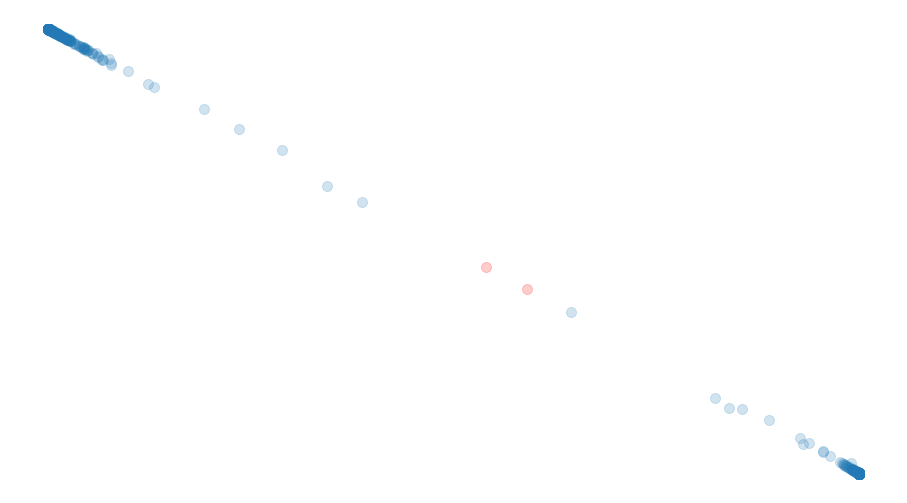

In [24]:
"""Load most recent model and make prediction on entire dataset"""

import os
current_dir = os.getcwd()
model_name = max(os.listdir('models'))
#model_name = '1620534697'
#for model_name in os.listdir('models'):
#for model_name in ['1620964737', '1620963157']:
    
model_path = os.path.join(current_dir, 'models', model_name)
model_static_path = os.path.join(current_dir, 'scripts', 'static', 'modelpredictions', model_name)
prediction_file = os.path.join(current_dir, 'scripts', 'static', 'modelpredictions', model_name, 'predictions.csv')
strings_file = os.path.join(current_dir, 'scripts', 'static', 'modelpredictions', model_name, 'strings.csv')
summary_file = os.path.join(current_dir, 'scripts', 'static', 'modelpredictions', model_name, 'summary.txt')
image_file = os.path.join(current_dir, 'scripts', 'static', 'modelpredictions', model_name, f'{model_name}graph.png')
model = load_model(model_path)

testDF = pd.read_csv('data/data.csv')

validation_list = []
for i in range(len(testDF.index)):
    path = testDF.iloc[i]['ResizedPath']
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    validation_list.append(image)

V = np.array(validation_list)
V = V/255
V = V.reshape(-1,135,240,1)

validation_results = model.predict(V)
resultsDF = pd.DataFrame(validation_results, columns= ['LikelyEmpty', 'LikelyBaby'])

testDF = pd.concat([testDF, resultsDF], axis=1)

testDF['Value'] = testDF.apply(lambda row: 'Baby' if row.Value else 'No Baby', axis=1)
testDF['Prediction'] = testDF.apply(lambda row: 'Baby' if row.LikelyBaby > row.LikelyEmpty else 'No Baby', axis=1)
testDF['Incorrect'] = testDF.apply(lambda row: 1 if row.Value != row.Prediction else 0, axis=1)

baby_total = testDF.loc[(testDF['Value'] == 'Baby')].index.size
baby_incorrect = testDF.loc[(testDF['Value'] == 'Baby') & (testDF['Incorrect'] == 1)].index.size
baby_incorrect_per = round(100 * baby_incorrect / baby_total, 2)
baby_incorrect_str = f'{baby_incorrect} of {baby_total} images with the baby misclassified. Error rate {baby_incorrect_per}%'

no_baby_total = testDF.loc[(testDF['Value'] == 'No Baby')].index.size
no_baby_incorrect = testDF.loc[(testDF['Value'] == 'No Baby') & (testDF['Incorrect'] == 1)].index.size
no_baby_incorrect_per = round(100 * no_baby_incorrect / no_baby_total, 2)
no_baby_incorrect_str = f'{no_baby_incorrect} of {no_baby_total} images without baby misclassified. Error rate {no_baby_incorrect_per}%'

inaccurate_counts_message = f'Innacurate classifications:\n{baby_incorrect_str}\n{no_baby_incorrect_str}'
print(f'{model_name}\n{inaccurate_counts_message}')

stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
shitty_string = '================================================================='
stringlist = [line if line not in shitty_string else '======================================' for line in stringlist ]
short_model_summary = "\n".join(stringlist)
if not os.path.exists(model_static_path):
    os.mkdir(model_static_path)
with open(prediction_file, 'w+', newline='') as f:
    testDF.to_csv(f, index=False, header=True)

with open(summary_file, 'w') as f:
        f.write(short_model_summary)
        
accurateDF = testDF.loc[testDF['Incorrect'] == 0].reset_index()
inaccurateDF = testDF.loc[testDF['Incorrect'] == 1].reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(16,9))
#Plot correct predictions in blue, incorrect in red
plt.scatter(accurateDF['LikelyEmpty'], accurateDF['LikelyBaby'], alpha=.2, s=100)
plt.scatter(inaccurateDF['LikelyEmpty'], inaccurateDF['LikelyBaby'], color='red', alpha=.2, s=100)

#Plot mid-lines
# plt.plot([0,1], [0,1], color='gray', lw=.5)
# plt.plot([0,1], [1,0], color='gray', lw=.5, linestyle= 'dotted')

plt.xlim([-.05,1.05])
plt.ylim([-.05,1.05])
plt.axis('off')
plt.savefig(image_file, facecolor=(1,1,1,1))

## Test functions, not part of typical workflow

In [ ]:
"""Display items output from generator. Just for testing generator settings"""

datagen = ImageDataGenerator(
                                rotation_range= 3,
                                width_shift_range= .05,
                                height_shift_range= .05,
                                zoom_range= 0.2, 
                                shear_range= 0.1
                                #brightness_range= [.95, 1.05], # Causes image to scale back to 0-255
                            )

plt.figure(figsize=(25,12))
for i in range(10):
    img, value = datagen.flow(Xaug, yaug, batch_size=1).next()
    img = img.reshape(135, 240,1)
    img = img*255
    plt.subplot(1, 10, i+1)
    plt.title(value[0])
    plt.imshow(img.astype('uint8'), cmap= 'gray')

In [ ]:
"""Fit model with imagegenerator."""
datagen = ImageDataGenerator(
                                rotation_range= 5,
                                #width_shift_range= .1,
                                #height_shift_range= .1,
                                zoom_range= 0.1, 
                                #shear_range= 0.1
                                #brightness_range= [.95, 1.05], # Causes image to scale back to 0-255
                            )
epochs = 5

divisible_by = [x for x in range(2,20) if X_train.shape[0] % x == 0]
batch_size = max(divisible_by)
print(f'Batch size: {batch_size}, {X_train.shape[0]} training images')

model.fit(
            datagen.flow(X_train, y_train, batch_size= batch_size),
            epochs= epochs,
            steps_per_epoch= X_train.shape[0] // batch_size,
            validation_data=(X_test, y_test),
            callbacks= [tensorboard]
)

In [ ]:
"""Load all models and make prediction on entire dataset"""

import os
current_dir = os.getcwd()
#model_name = max(os.listdir('models'))
for model_name in os.listdir('models'):
    
    model_path = os.path.join(current_dir, 'models', model_name)
    prediction_file = os.path.join(current_dir, 'static', 'modelpredictions', model_name, 'predictions.csv')
    strings_file = os.path.join(current_dir, 'static', 'modelpredictions', model_name, 'strings.csv')
    summary_file = os.path.join(current_dir, 'static', 'modelpredictions', model_name, 'summary.txt')
    image_file = os.path.join(current_dir, 'static', 'modelpredictions', model_name, f'{model_name}graph.png')
    model = load_model(model_path)

    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    shitty_string = '================================================================='
    stringlist = [line if line not in shitty_string else '======================================' for line in stringlist ]
    short_model_summary = "\n".join(stringlist)

    with open(summary_file, 'w') as f:
        f.write(short_model_summary)
